In [4]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import geopandas
import math
import time
from pyspark.sql.functions import col
np.random_state=42

In [3]:
from pyspark import SparkContext,SQLContext
sc = SparkContext()
sqlContext = SQLContext(sc)

In [5]:
data_extracted = pd.read_csv('data_extracted.csv')
sample_geo = pd.read_csv('sample_geo.txt',sep='\t')
lat_longs = pd.read_csv('lat_longs.csv')

In [6]:

def GreatCircleDistance(point1,point2):
    radians = math.pi/180.0

    phi1 = (90.0 - point1[0])*radians
    phi2 = (90.0 - point2[0])*radians
        
    theta1 = point1[1]*radians
    theta2 = point2[1]*radians
   
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) + 
           math.cos(phi1)*math.cos(phi2))
    dist = math.acos( cos )

    return dist

In [7]:
def EuclideanDistance(point1,point2):
    point1,point2 = np.array(point1),np.array(point2)
    dist = np.linalg.norm(point1 - point2) 
    return dist

In [8]:
def addPoints(distance,point,centroids):
    if distance == 'Euclidean':
                dist = [EuclideanDistance(point,centroids[centroid]) for centroid in centroids]
                
    if distance == 'GreatCircle':
                dist = [GreatCircleDistance(point,centroids[centroid]) for centroid in centroids]
    return dist
  

In [9]:
def closestPoint(points,distance,k=3,convergeDist=0.0001,max_iter=1000):
    points = np.array(points).T
    
    centroids = {}
    pt = np.random.randint(low=0, high=len(points), size=k)

    for i in range(k):
        centroids[i] = points[pt[i]]

    for i in range(max_iter):
        classifications = {}
        for j in range(k):
            classifications[j] = []
        for point in points:
            dist = addPoints(distance,point,centroids)
            cluster = dist.index(min(dist))
            
            classifications[cluster].append(point)
          
        pre_center = dict(centroids)
        for classes in classifications:
            centroids[classes] = np.average(classifications[classes],axis=0)
        
        opt = True
        for center in centroids:
            org_center = pre_center[center]
            cur_center = centroids[center]
            if np.sum((cur_center-org_center)/org_center * 100.0) > convergeDist:
                opt = False
        
        if opt:
          break
        
    return centroids

In [10]:
def plot(centers,long,lat):
    X,Y = [],[]
    for i in centers.values():
        Y.append(i[0])
        X.append(i[1])
        
    plt.scatter(long,lat)
    plt.scatter(X,Y)

In [11]:
s_time = time.time()
centers = closestPoint([data_extracted.latitude,data_extracted.longitude],k=5,distance='Euclidean')
device_locationTime = time.time()-s_time

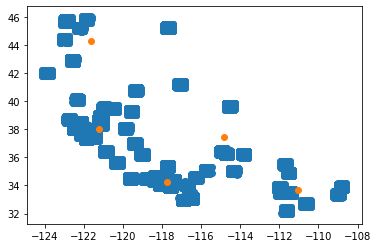

In [12]:
plot(centers,data_extracted.longitude,data_extracted.latitude)

In [13]:
s_time = time.time()
centers = closestPoint([data_extracted.latitude,data_extracted.longitude],k=5,distance='GreatCircle')
device_locationTime_Circle = time.time()-s_time

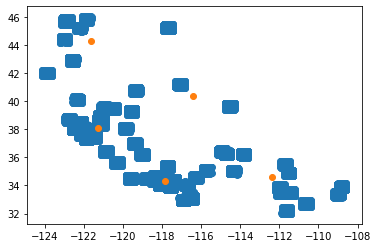

In [14]:
plot(centers,data_extracted.longitude,data_extracted.latitude)

In [26]:
print("TIme for Euclidean Distance: {}\nTime for GreatCircle Distance: {}".format(device_locationTime,device_locationTime_Circle))

TIme for Euclidean Distance: 38.056023597717285
Time for GreatCircle Distance: 20.87254571914673


In [27]:
# Euclidean Distance(K = 2)
s_time = time.time()
centers = closestPoint([sample_geo.Latitude,sample_geo.Longitude],k=2,distance='Euclidean')
sampleGeoTime_2euc = time.time()-s_time

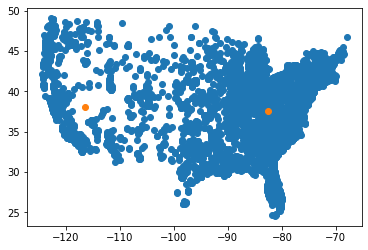

In [28]:
plot(centers,sample_geo.Longitude,sample_geo.Latitude)

In [29]:
# GreatCircle Distance with K = 2
s_time = time.time()
centers = closestPoint([sample_geo.Latitude,sample_geo.Longitude],k=2,distance='GreatCircle')
sampleGeoTime_2cir = time.time()-s_time

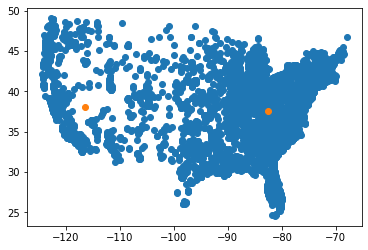

In [30]:
plot(centers,sample_geo.Longitude,sample_geo.Latitude)

In [32]:
print("TIme for Euclidean Distance: {}\nTime for GreatCircle Distance: {}".format(sampleGeoTime_2euc,sampleGeoTime_2cir))

TIme for Euclidean Distance: 1.3118581771850586
Time for GreatCircle Distance: 0.649526834487915


In [33]:
# Euclidean Distance(K = 4)
s_time = time.time()
centers = closestPoint([sample_geo.Latitude,sample_geo.Longitude],k=4,distance='Euclidean')
sampleGeoTime_4euc = time.time()-s_time

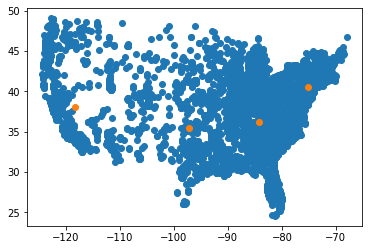

In [34]:
plot(centers,sample_geo.Longitude,sample_geo.Latitude)

In [35]:
# GreatCircle Distance with K = 4
s_time = time.time()
centers = closestPoint([sample_geo.Latitude,sample_geo.Longitude],k=4,distance='GreatCircle')
sampleGeoTime_4cir = time.time()-s_time

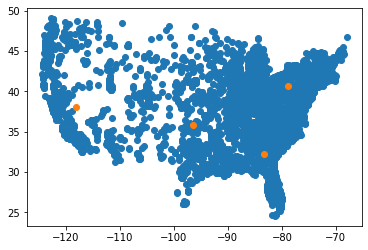

In [36]:
plot(centers,sample_geo.Longitude,sample_geo.Latitude)

In [37]:
print("TIme for Euclidean Distance: {}\nTime for GreatCircle Distance: {}".format(sampleGeoTime_4euc,sampleGeoTime_4cir))

TIme for Euclidean Distance: 5.511715888977051
Time for GreatCircle Distance: 1.5558748245239258
